In [1]:
import pandas as pd
import numpy as np
import ast
from itertools import combinations
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import scikit_posthocs as sp
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.formula.api import mixedlm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

### yes questions

In [2]:
df_with_features_h = pd.read_csv('df_with_features_h.csv')
df_with_features_g = pd.read_csv('df_with_features_g.csv')

### literal columns

In [3]:
cols = ['simpl_fix_by_label', 'simpl_fix_by_loc', 'first_visits_area_screen_loc', 'first_visits_area_label',
        'last_visits_area_screen_loc', 'last_visits_area_label', 'first_visits_area_screen_loc_with_q',
        'first_visits_area_label_with_q', 'last_visits_area_screen_loc_with_q', 'last_visits_area_label_with_q' ]

def parse_cols(df: pd.DataFrame, columns=None):
    df = df.copy()
    cols = df.columns if columns is None else columns

    def _parse_cell(x):
        if pd.isna(x) or isinstance(x, tuple):
            return x
        if isinstance(x, str):
            try:
                val = ast.literal_eval(x)
                if isinstance(val, list):
                    return tuple(val)
                if isinstance(val, tuple):
                    return val
            except (SyntaxError, ValueError):
                pass
        return x

    for col in cols:
        df[col] = df[col].apply(_parse_cell)

    return df


df_with_features_h = parse_cols(df_with_features_h,columns=cols)
df_with_features_g = parse_cols(df_with_features_g, columns=cols)

### no questions

In [4]:
df_noq_h = df_with_features_h[df_with_features_h['area_label'] != 'question']
df_noq_g = df_with_features_g[df_with_features_g['area_label'] != 'question']

### Basic Stats Heatmaps

In [5]:
def matrix_plot_ABCD(df, stat, selected = 'A', h_or_g = 'hunters'):
    df = df[['TRIAL_INDEX', 'participant_id', 'area_label', 'area_screen_loc', stat]].drop_duplicates().copy()
    matrix = pd.pivot_table(
        data=df,
        index='area_label',
        columns='area_screen_loc',
        values=stat,
        aggfunc='mean'
    )

    sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    cbar_kws={'label': f'{stat}'}
    )

    plt.title(f"{stat} of those who chose {selected} ")
    plt.xlabel('area_screen_loc')
    plt.ylabel("area_label")
    plt.tight_layout()
    #plt.savefig(f"new_plots/basic_stats_heatmaps/{h_or_g}_{stat}_{selected}.png")

    plt.show()

In [6]:
def label_vs_loc_mat(metric, dfh, dfg):
    print("HUNTERS")
    for ans in ['A', 'B', 'C', 'D']:
        matrix_plot_ABCD(dfh[dfh['selected_answer_label'] == ans], metric, selected=ans, h_or_g='hunters')
    print("GATHERERS")
    for ans in ['A', 'B', 'C', 'D']:
        matrix_plot_ABCD(dfg[dfg['selected_answer_label'] == ans], metric, selected=ans, h_or_g='gatherers')


HUNTERS


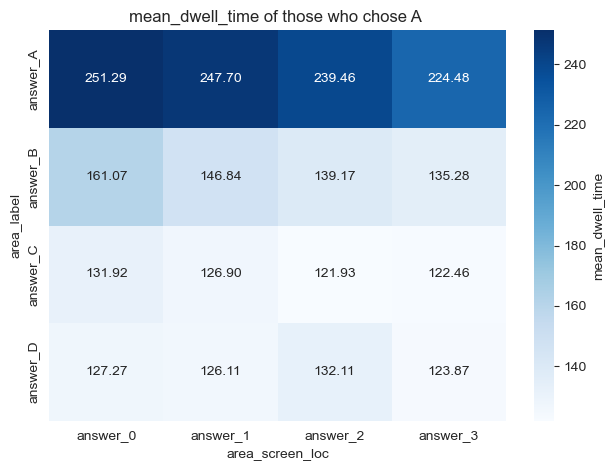

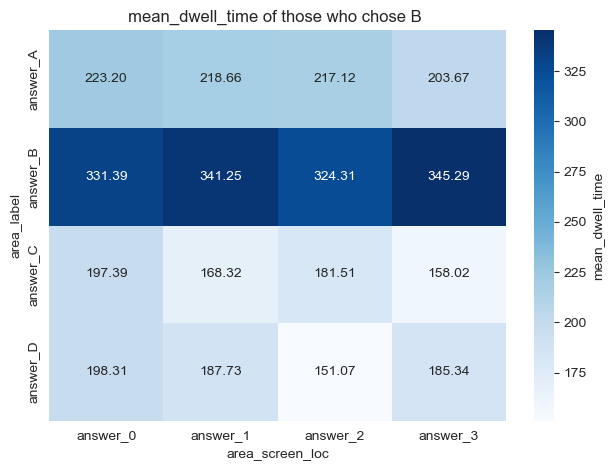

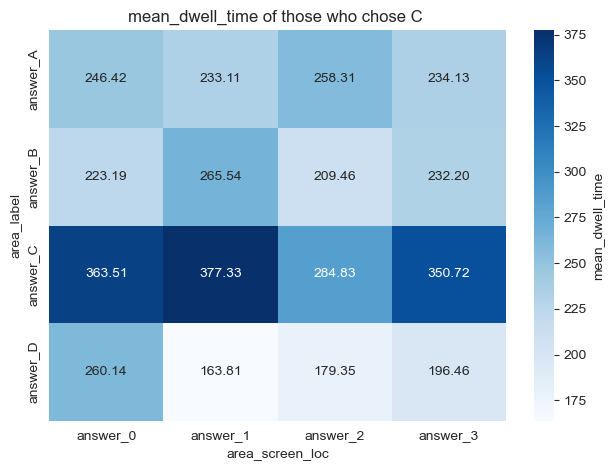

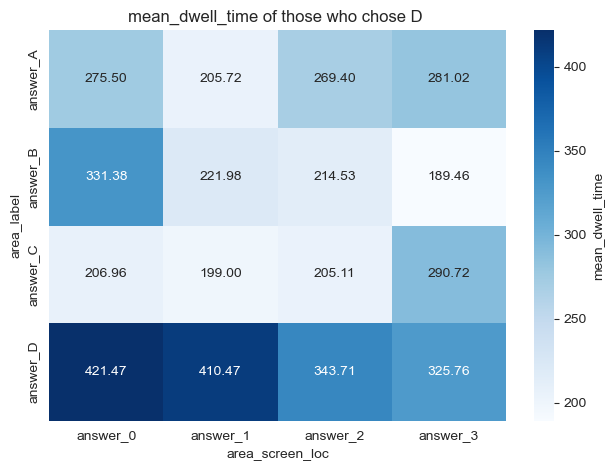

GATHERERS


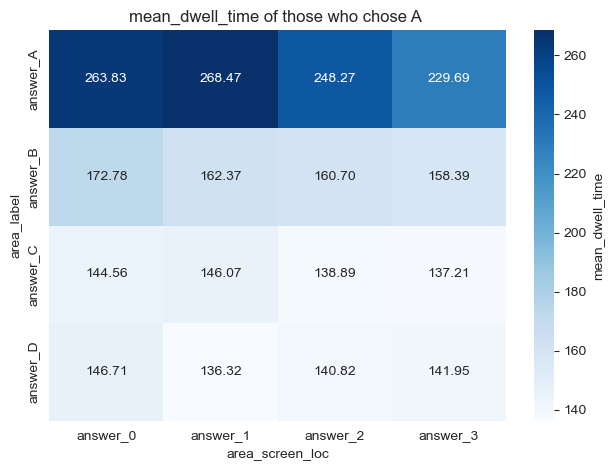

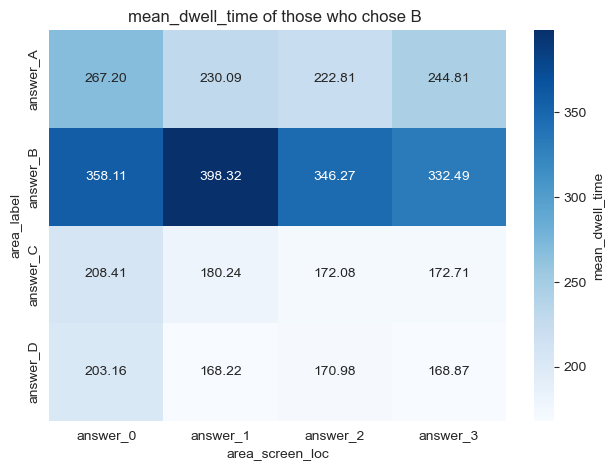

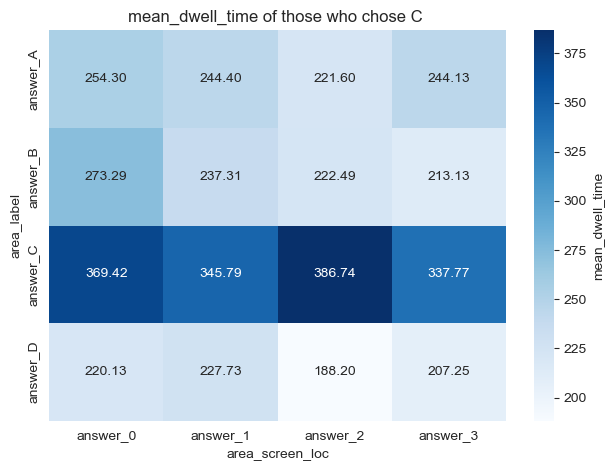

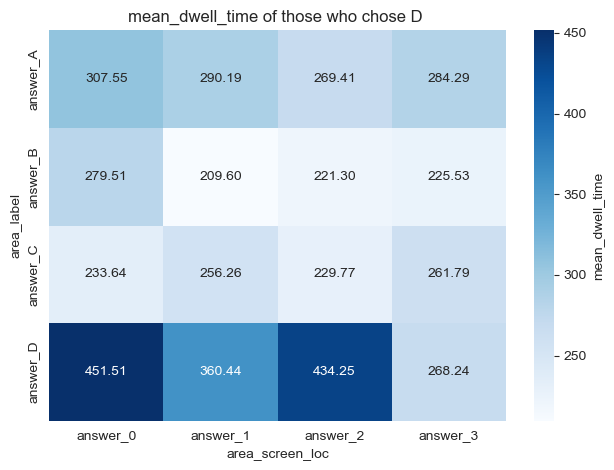

In [7]:
label_vs_loc_mat('mean_dwell_time', df_noq_h, df_noq_g)

In [8]:
df_noq_h[['IA_LABEL','participant_id', 'text_id', 'TRIAL_INDEX', 'area_label', 'mean_dwell_time', 'selected_answer_label']]

,IA_LABEL,participant_id,text_id,TRIAL_INDEX,area_label,mean_dwell_time,selected_answer_label
4,A,l42_2070,6_Ele_3_1,4,answer_B,173.000000,A
5,company,l42_2070,6_Ele_3_1,4,answer_B,173.000000,A
6,that,l42_2070,6_Ele_3_1,4,answer_B,173.000000,A
7,will,l42_2070,6_Ele_3_1,4,answer_B,173.000000,A
8,soon,l42_2070,6_Ele_3_1,4,answer_B,173.000000,A
...,...,...,...,...,...,...,...
380345,the,l10_39,5_Adv_1_5,59,answer_B,142.833333,A
380346,head,l10_39,5_Adv_1_5,59,answer_B,142.833333,A
380347,of,l10_39,5_Adv_1_5,59,answer_B,142.833333,A
380348,the,l10_39,5_Adv_1_5,59,answer_B,142.833333,A


### Basic Stats Boxplots

In [9]:
def boxplot_ABCD_avg(df, stat, selected='A', h_or_g='hunters'):
    df = df[['TRIAL_INDEX', 'participant_id', 'area_label', 'area_screen_loc', stat]].drop_duplicates().copy()

    df_avg = (
        df.groupby(['participant_id', 'area_label'])[stat]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=df_avg,
        x='area_label',
        y=stat,
    )

    plt.title(f"{stat} distribution (averaged across screen locations) of those who chose {selected}")
    plt.xlabel('area_label')
    plt.ylabel(stat)
    plt.tight_layout()
    #plt.savefig(f"new_plots/basic_stats_boxplots/{h_or_g}_{stat}_{selected}.png")

    plt.show()


In [10]:
def label_vs_loc_box_sum(metric, dfh, dfg):
    print("HUNTERS")
    for ans in ['A', 'B', 'C', 'D']:
        boxplot_ABCD_avg(dfh[dfh['selected_answer_label'] == ans], metric, selected=ans, h_or_g='hunters')

    print("GATHERERS")
    for ans in ['A', 'B', 'C', 'D']:
        boxplot_ABCD_avg(dfg[dfg['selected_answer_label'] == ans], metric, selected=ans, h_or_g='gatherers')


HUNTERS


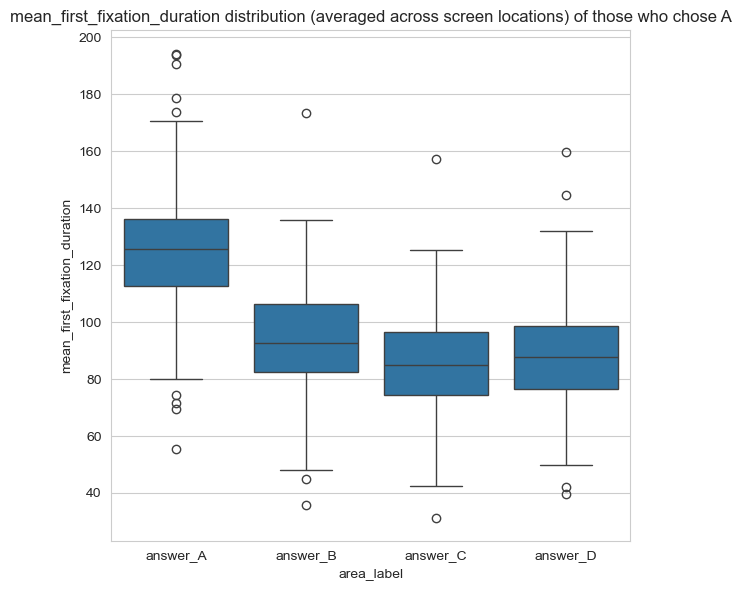

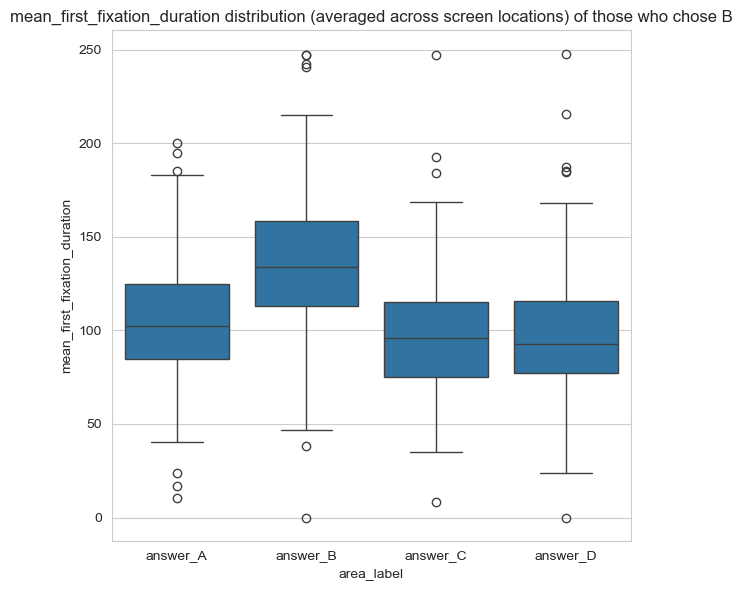

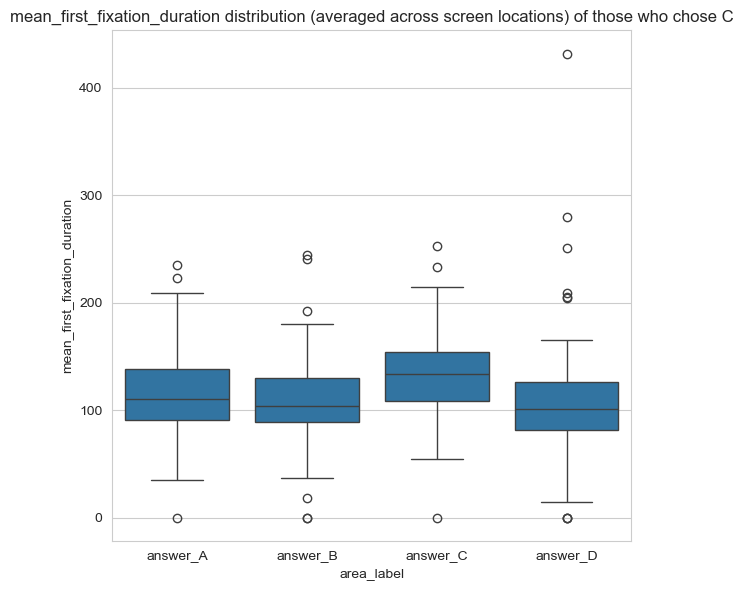

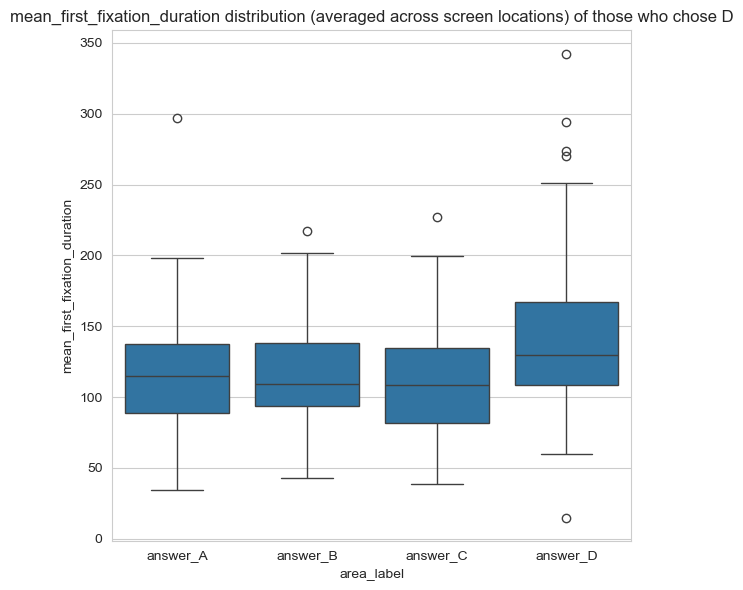

GATHERERS


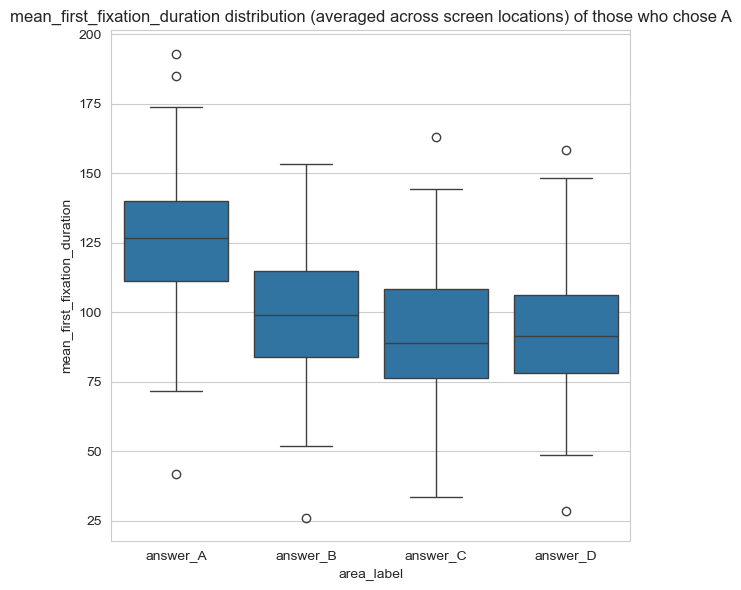

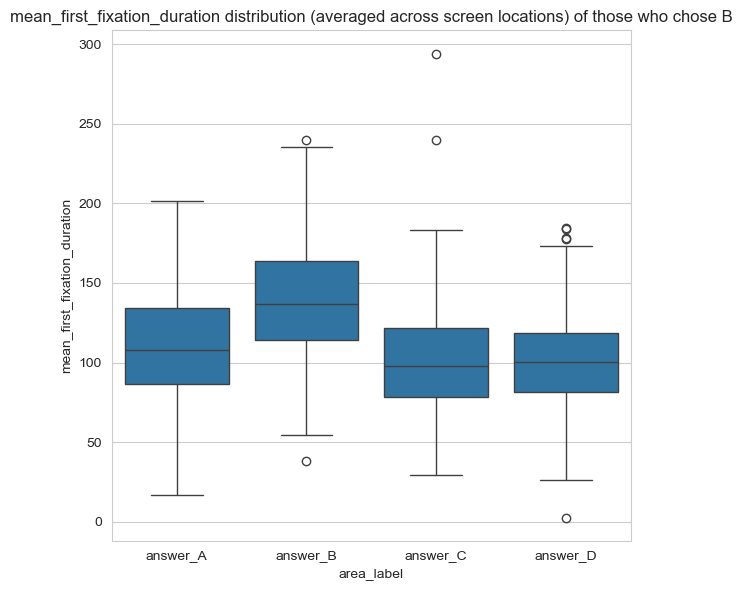

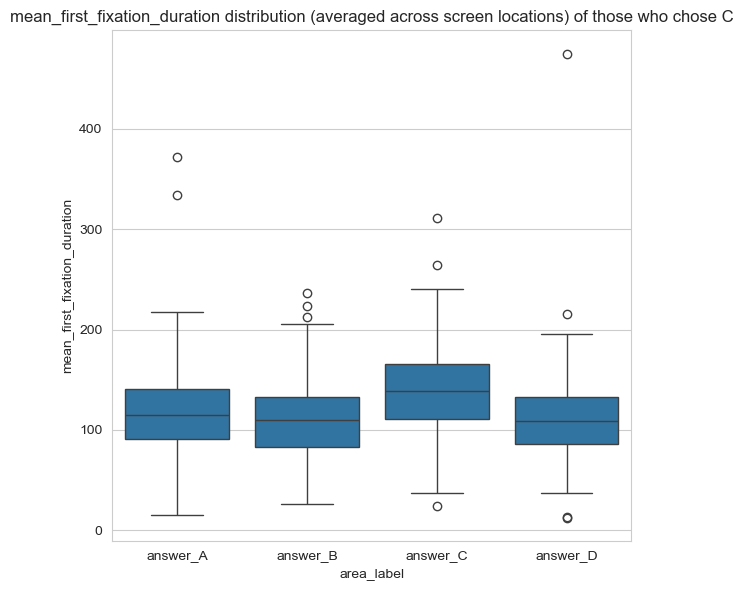

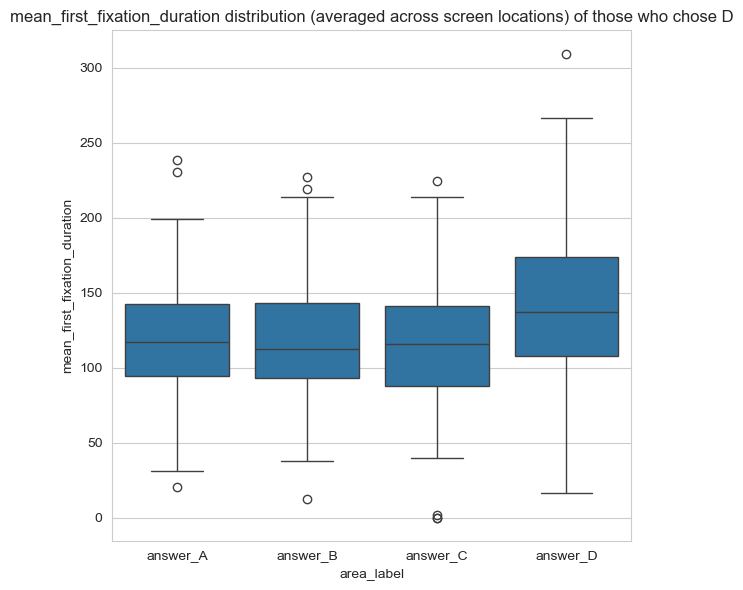

In [11]:
label_vs_loc_box_sum('mean_first_fixation_duration', df_noq_h, df_noq_g)

In [12]:
#TODO
## bar plot with 95% conf + stat exam
## apendix the rest of stats. word skips / regressions etc/

### Bar chart

In [13]:
def plot_area_ci_bar(
    df,
    stat_col="mean_dwell_time",
    trial_cols=("participant_id", "text_id", "TRIAL_INDEX"),
    area_col="area_label",
    figsize=(8, 5),
    save=False,
    h_or_g ='hunters',
    selected = 'A',
    title=None,):

    dedup = (
        df[list(trial_cols) + [area_col, stat_col]]
        .drop_duplicates(subset=list(trial_cols) + [area_col])
        .dropna(subset=[stat_col])
    )

    area_order = [a for a in ["answer_A", "answer_B", "answer_C", "answer_D"]
                  if a in dedup[area_col].unique()]

    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=dedup,
        x=area_col,
        y=stat_col,
        order=area_order if area_order else None,
        estimator=np.mean,
        errorbar=("ci", 95),
        capsize=0.1,
        ax=ax,
    )
    ax.set_xlabel(area_col)
    ax.set_ylabel(stat_col)
    ax.set_title(title or f"{stat_col}: mean ± 95% CI by {area_col}")
    ax.margins(x=0.02)

    summary_df_basic = (
        dedup.groupby(area_col)[stat_col]
        .agg(mean="mean", sd="std", n="count")
        .reset_index()
    )
    if area_order:
        summary_df_basic = summary_df_basic.set_index(area_col).loc[area_order].reset_index()
    if save:
        plt.savefig(f"third_plots/basic_stats/barcharts/{stat_col}/{h_or_g}__{selected}.png")
    return fig, summary_df_basic



In [14]:
def mixed_area_analysis(
    df,
    stat_col="mean_dwell_time",
    trial_cols=("participant_id", "text_id", "TRIAL_INDEX"),
    area_col="area_label",
    alpha=0.05,
):

    dedup = (
        df[list(trial_cols) + [area_col, stat_col]]
        .drop_duplicates()
        .copy()
    )

    area_order = [a for a in ["answer_A","answer_B","answer_C","answer_D"]
                  if a in dedup[area_col].unique()]
    if not area_order:
        area_order = sorted(dedup[area_col].unique())

    dedup[area_col] = pd.Categorical(dedup[area_col], categories=area_order, ordered=True)


    formula = f"{stat_col} ~ 0 + C({area_col})"
    model = smf.mixedlm(
        formula,
        data=dedup,
        groups=dedup['participant_id'],
        re_formula="1",
        vc_formula={"text": f"1 + C(text_id)"}
    )
    result = model.fit(method="lbfgs", reml=True)


    fe_idx = result.fe_params.index.tolist()
    def pname(level):
        for nm in fe_idx:
            if nm.endswith(f"[{level}]") or nm.endswith(f"[T.{level}]"):
                return nm

    fe = result.fe_params.copy()
    ci = result.conf_int(alpha=alpha).loc[fe.index]
    fe_table = (
        pd.DataFrame({
            "term": fe.index,
            "estimate": fe.values,
            "ci_low": ci[0].values,
            "ci_high": ci[1].values
        })
        .assign(area=lambda d: d["term"].str.extract(r"\[(?:T\.)?([^\]]+)\]"))
        .set_index("area").loc[area_order].reset_index()
    )

    pairs = []
    k_fe = len(fe_idx)

    for i in range(len(area_order)):
        for j in range(i+1, len(area_order)):
            a, b = area_order[i], area_order[j]
            L = np.zeros((1, k_fe))
            L[0, fe_idx.index(pname(a))] =  1.0
            L[0, fe_idx.index(pname(b))] = -1.0

            t_res = result.t_test(L)
            eff   = float(np.asarray(t_res.effect).ravel()[0])
            se    = float(np.asarray(t_res.sd).ravel()[0])
            tval  = float(np.asarray(t_res.tvalue).ravel()[0])
            pval  = float(np.asarray(t_res.pvalue).ravel()[0])
            ci_lo, ci_hi = np.asarray(t_res.conf_int(alpha=alpha)).ravel()

            pairs.append({
                "area_i": a, "area_j": b,
                "diff_i_minus_j": eff,
                "se": se, "t": tval, "p_unc": pval,
                "ci_low": ci_lo, "ci_high": ci_hi
            })

    pairwise = pd.DataFrame(pairs)
    pairwise["p_adj_holm"] = multipletests(pairwise["p_unc"], method="holm")[1]
    pairwise["sig"] = np.where(pairwise["p_adj_holm"] < alpha, "★", "")

    return result, fe_table, pairwise



In [ ]:
fig, summary = plot_area_ci_bar(df_noq_h[df_noq_h['selected_answer_label'] == 'A'], stat_col="mean_dwell_time")
res, fe_table, pw = mixed_area_analysis(df_noq_h[df_noq_h['selected_answer_label'] == 'A'], stat_col="mean_dwell_time")

print(res.summary())
display(pw.sort_values("p_adj_holm"))

HUNTERS


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


-----------answer A---------
                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:    33796      Method:                REML           
No. Groups:          180        Scale:                 14493.2384     
Min. group size:     116        Log-Likelihood:        -214886.5742   
Max. group size:     216        Converged:             Yes            
Mean group size:     187.8                                            
----------------------------------------------------------------------
                         Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
C(area_label)[answer_A]  241.235    6.740 35.791 0.000 228.024 254.445
C(area_label)[answer_B]  145.911    6.740 21.648 0.000 132.700 159.121
C(area_label)[answer_C]  126.097    6.740 18.708 0.000 112.886 139.307
C(area_label)[answer_D]  127.684    6.740 18.944 0.000 114.473 14

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


-----------answer B---------
                 Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:     2976       Method:                REML           
No. Groups:           175        Scale:                 27104.3838     
Min. group size:      4          Log-Likelihood:        -20014.3356    
Max. group size:      44         Converged:             Yes            
Mean group size:      17.0                                             
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
C(area_label)[answer_A]   213.962   14.176 15.093 0.000 186.178 241.747
C(area_label)[answer_B]   333.984   14.176 23.560 0.000 306.200 361.769
C(area_label)[answer_C]   175.765   14.176 12.399 0.000 147.981 203.549
C(area_label)[answer_D]   179.986   14.176 12.697 0.

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


-----------answer D---------
                 Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:     608        Method:                REML           
No. Groups:           91         Scale:                 29581.8264     
Min. group size:      4          Log-Likelihood:        -4109.6067     
Max. group size:      24         Converged:             Yes            
Mean group size:      6.7                                              
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
C(area_label)[answer_A]   256.879   24.328 10.559 0.000 209.196 304.561
C(area_label)[answer_B]   230.689   24.328  9.482 0.000 183.007 278.372
C(area_label)[answer_C]   221.915   24.328  9.122 0.000 174.232 269.597
C(area_label)[answer_D]   369.961   24.328 15.207 0.

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


-----------answer A---------
                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:    31560      Method:                REML           
No. Groups:          180        Scale:                 15955.3311     
Min. group size:     104        Log-Likelihood:        -202447.5054   
Max. group size:     212        Converged:             Yes            
Mean group size:     175.3                                            
----------------------------------------------------------------------
                         Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
C(area_label)[answer_A]  253.425    7.415 34.177 0.000 238.892 267.958
C(area_label)[answer_B]  164.106    7.415 22.131 0.000 149.573 178.640
C(area_label)[answer_C]  142.255    7.415 19.184 0.000 127.721 156.788
C(area_label)[answer_D]  142.111    7.415 19.165 0.000 127.578 15

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


-----------answer B---------
                 Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:     4000       Method:                REML           
No. Groups:           179        Scale:                 44122.1352     
Min. group size:      4          Log-Likelihood:        -27617.8383    
Max. group size:      76         Converged:             Yes            
Mean group size:      22.3                                             
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
C(area_label)[answer_A]   236.040   13.045 18.095 0.000 210.473 261.608
C(area_label)[answer_B]   355.504   13.045 27.253 0.000 329.936 381.071
C(area_label)[answer_C]   179.895   13.045 13.791 0.000 154.328 205.462
C(area_label)[answer_D]   173.990   13.045 13.338 0.

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


-----------answer C---------
                 Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:     2272       Method:                REML           
No. Groups:           169        Scale:                 34438.7930     
Min. group size:      4          Log-Likelihood:        -15461.8952    
Max. group size:      44         Converged:             Yes            
Mean group size:      13.4                                             
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
C(area_label)[answer_A]   238.696   14.340 16.645 0.000 210.589 266.802
C(area_label)[answer_B]   232.990   14.340 16.247 0.000 204.883 261.097
C(area_label)[answer_C]   357.621   14.340 24.938 0.000 329.514 385.727
C(area_label)[answer_D]   209.319   14.340 14.597 0.

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


-----------answer D---------
                 Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    mean_dwell_time
No. Observations:     1036       Method:                REML           
No. Groups:           130        Scale:                 38659.2405     
Min. group size:      4          Log-Likelihood:        -7111.0666     
Max. group size:      24         Converged:             Yes            
Mean group size:      8.0                                              
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
C(area_label)[answer_A]   287.181   19.698 14.579 0.000 248.574 325.788
C(area_label)[answer_B]   231.607   19.698 11.758 0.000 193.000 270.214
C(area_label)[answer_C]   245.177   19.698 12.447 0.000 206.570 283.784
C(area_label)[answer_D]   379.668   19.698 19.275 0.

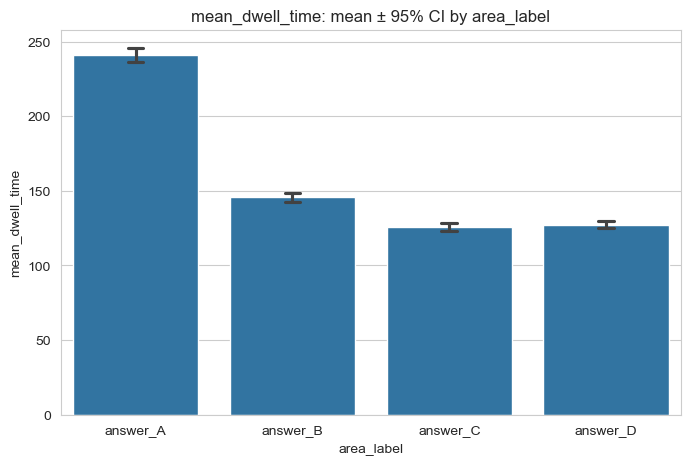

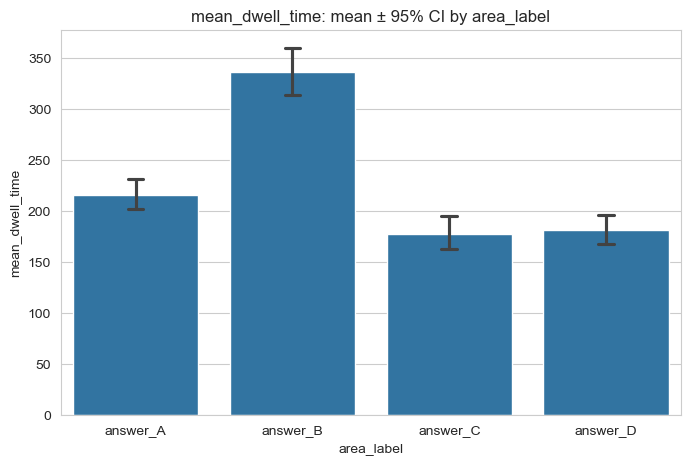

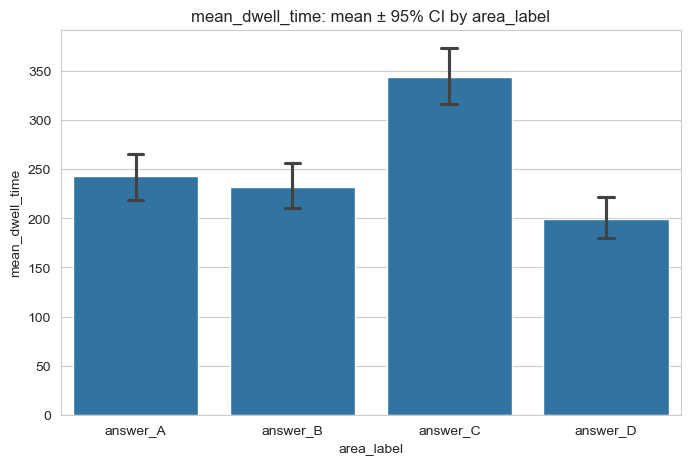

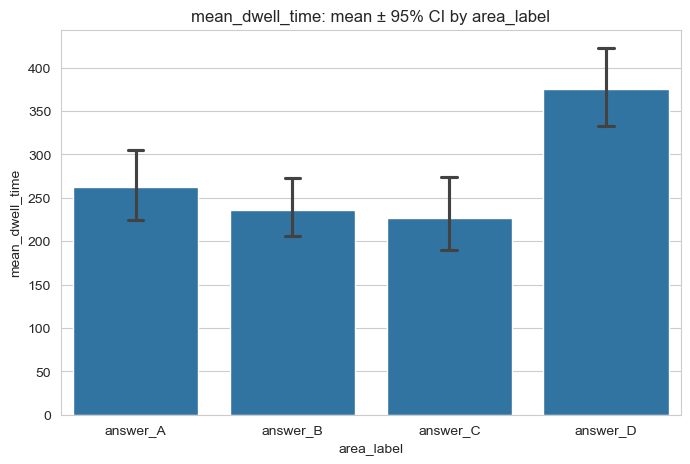

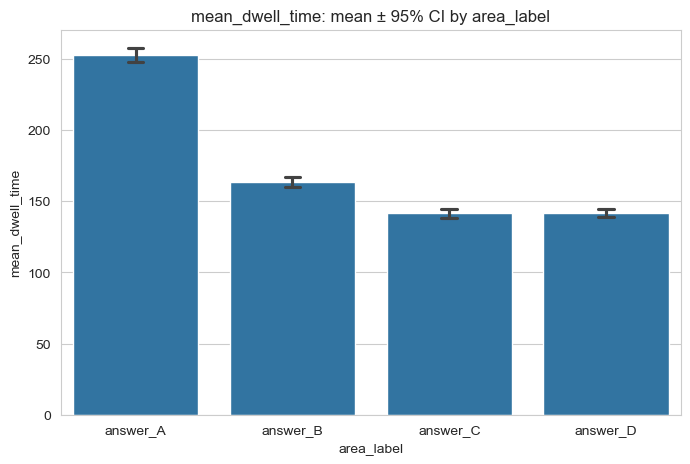

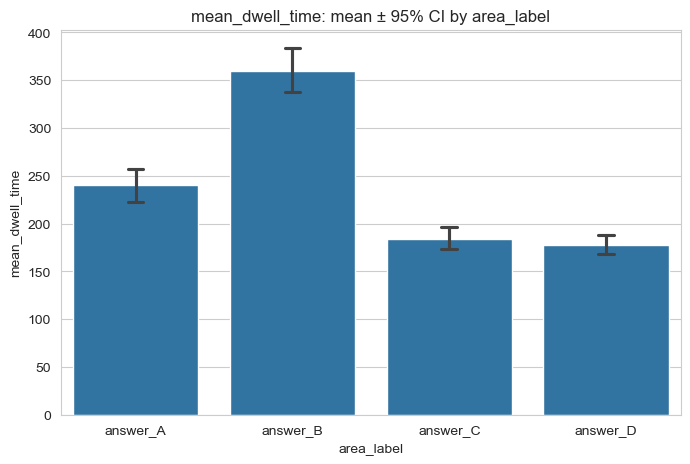

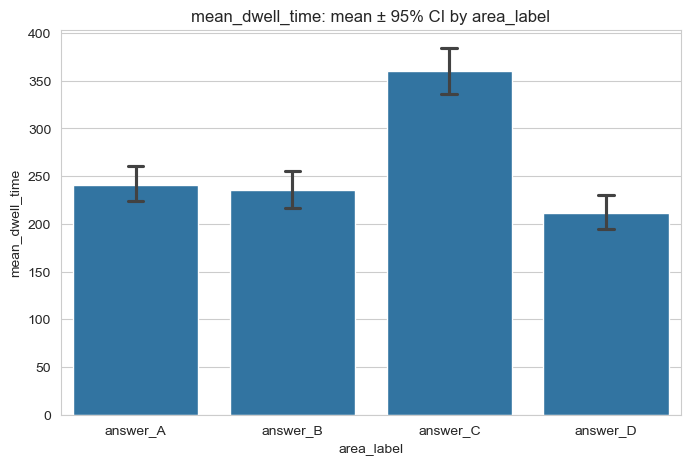

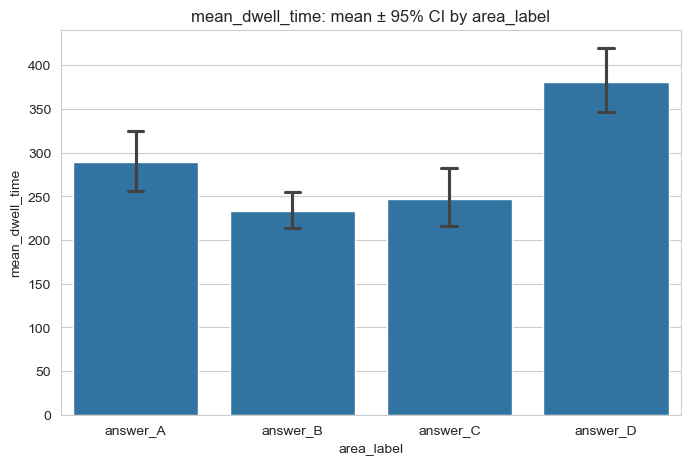

In [16]:
print("HUNTERS")
for ans in ['A', 'B', 'C', 'D']:
    fig, summary = plot_area_ci_bar(df_noq_h[df_noq_h['selected_answer_label'] == ans], stat_col="mean_dwell_time",
                                    save=True,selected=ans, h_or_g='hunters')
    res, fe_table, pw = mixed_area_analysis(df_noq_h[df_noq_h['selected_answer_label'] == ans], stat_col="mean_dwell_time")

    print(f'-----------answer {ans}---------')
    print(res.summary())
    print(pw.sort_values("p_adj_holm"))

print('GATHERERS')
for ans in ['A', 'B', 'C', 'D']:
    fig, summary = plot_area_ci_bar(df_noq_g[df_noq_g['selected_answer_label'] == ans], stat_col="mean_dwell_time",
                                    save=True,selected=ans, h_or_g='gatherers')
    res, fe_table, pw = mixed_area_analysis(df_noq_g[df_noq_g['selected_answer_label'] == ans], stat_col="mean_dwell_time")

    print(f'-----------answer {ans}---------')
    print(res.summary())
    print(pw.sort_values("p_adj_holm"))


### First / Last Visits Heatmaps

In [17]:
def matrix_plot_visits(df, stat, h_or_g = 'hunters', answ ='A', start_or_end = 'first'):
    df_selection = df[['TRIAL_INDEX', 'participant_id', stat]].drop_duplicates().copy()

    df_selection[stat] = df_selection[stat].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    df_selection['position'] = df_selection[stat].apply(lambda lst: list(range(len(lst))))

    df_exploded = df_selection.explode('position')
    df_exploded = df_exploded[df_exploded['position'].notna()]
    df_exploded['area'] = df_exploded.apply(
        lambda row: row[stat][int(row['position'])], axis=1
    )

    agg = df_exploded.groupby(['position', 'area']).size().reset_index(name='count')
    pivot_table = agg.pivot(index='position', columns='area', values='count').fillna(0)

    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_table, annot=True, fmt="g", cmap="viridis")
    plt.title(f"Frequency of Area Visits by {stat}")
    plt.xlabel("Area")
    plt.ylabel("Visit Order (position)")
    #plt.savefig(f"new_plots/{start_or_end}_visits/{stat}_{h_or_g}_{answ}.png")
    plt.show()

In [18]:
def plot_all_by_answer(matrix_plot_fn, dfh, dfg, with_questions=False, **kwargs):

    groups = {
        'hunters': dfh,
        'gatherers': dfg,
    }
    answers = ['A', 'B', 'C', 'D']
    starts = ['first', 'last']
    bases = ['visits_area_screen_loc', 'visits_area_label']
    suffix = "_with_q" if with_questions else ""

    sliced = {
        (g, a): df[df['selected_answer_label'] == a]
        for g, df in groups.items()
        for a in answers
    }

    for ans in answers:
        print(f'\nParticipants who answered {ans}:')
        print('--------------------------------------------------------------------------')
        for start in starts:
            print(f'####### {start.capitalize()} #######')
            for group in groups.keys():
                data = sliced[(group, ans)]
                for base in bases:
                    col = f'{start}_{base}{suffix}'
                    matrix_plot_fn(
                        data,
                        col,
                        h_or_g=group,
                        answ=ans,
                        start_or_end=start
                    )



Participants who answered A:
--------------------------------------------------------------------------
####### First #######


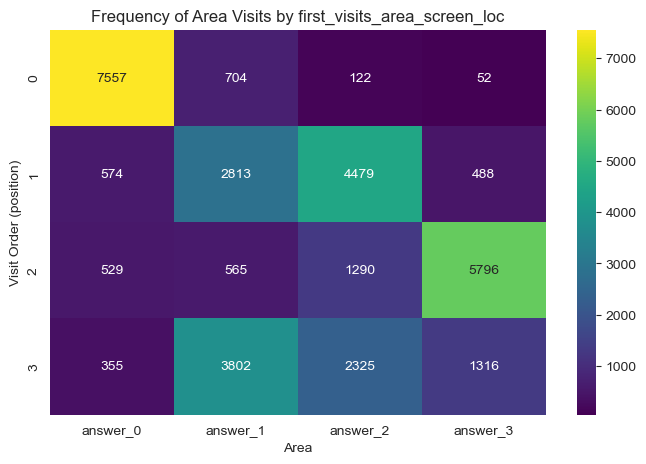

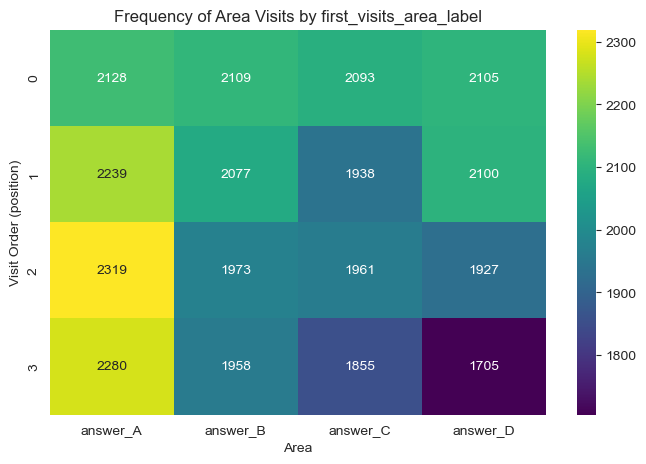

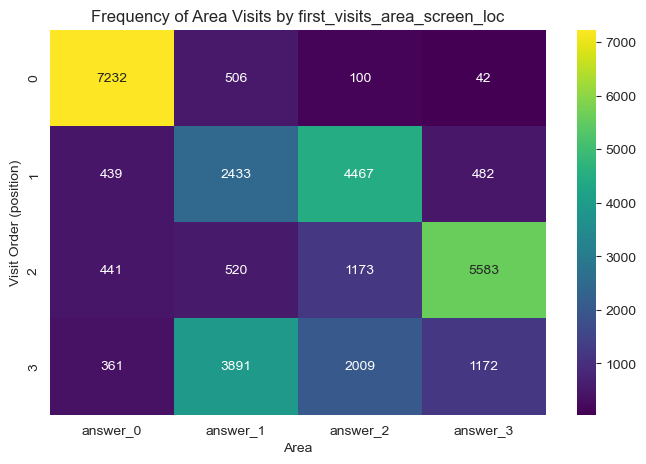

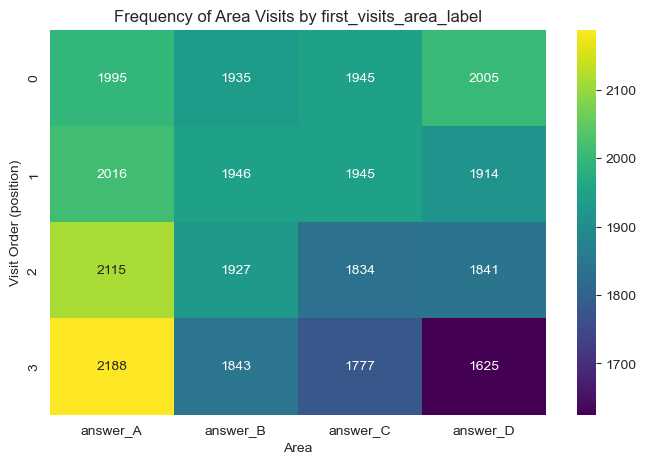

####### Last #######


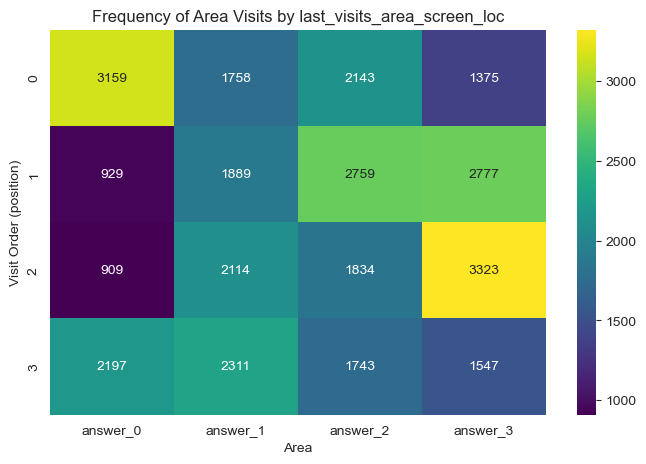

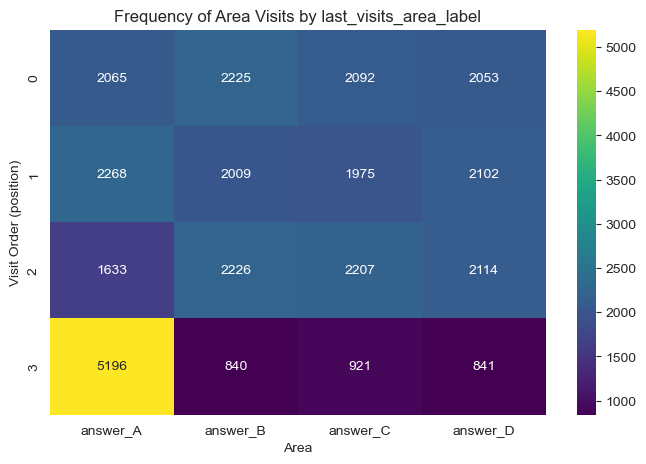

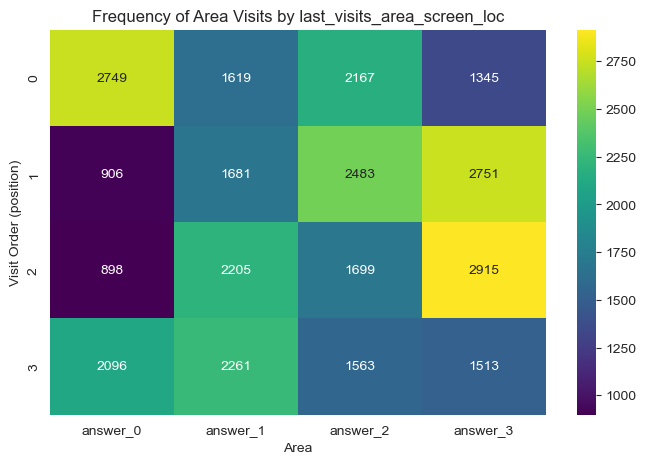

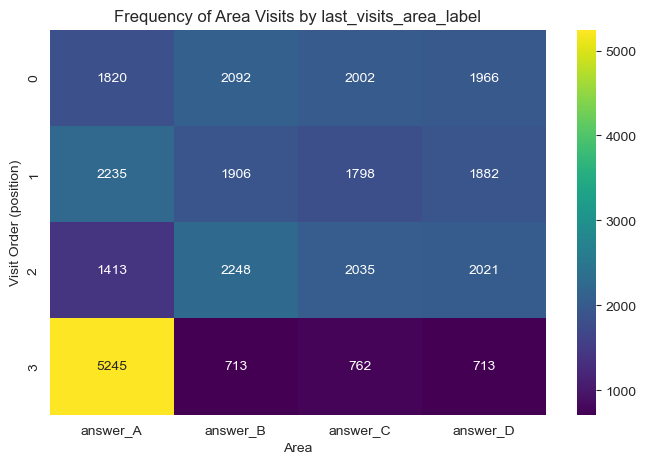


Participants who answered B:
--------------------------------------------------------------------------
####### First #######


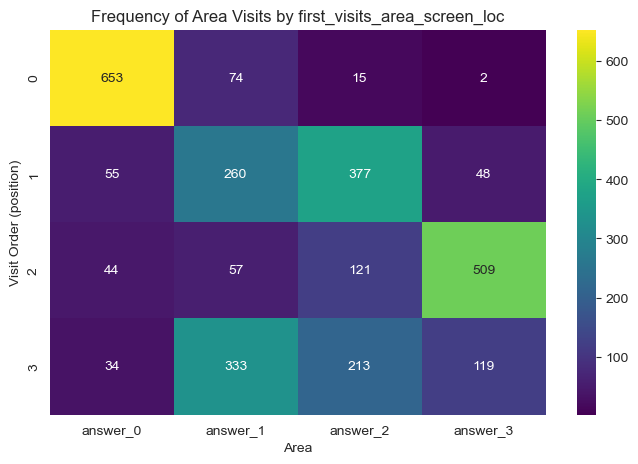

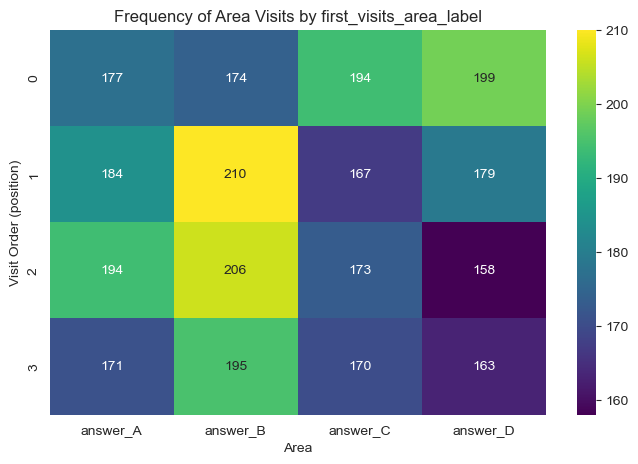

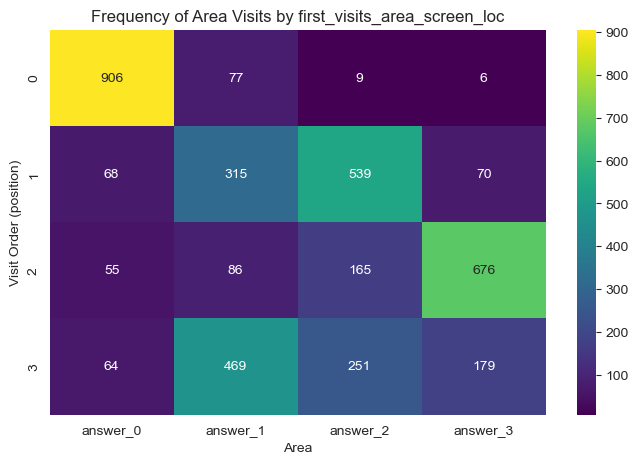

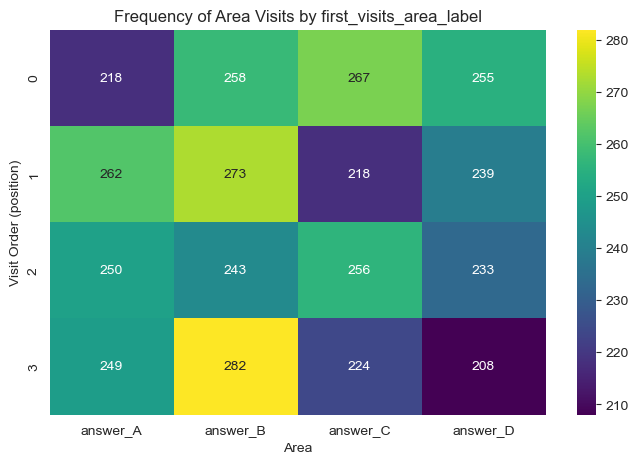

####### Last #######


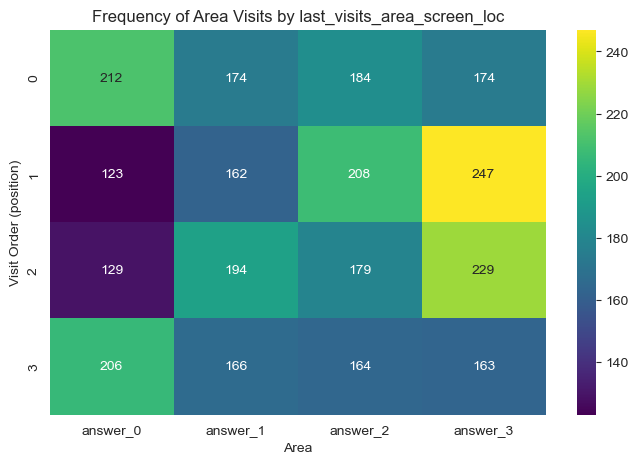

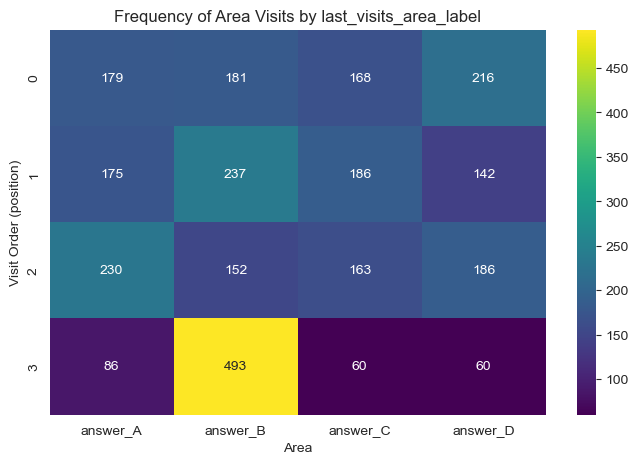

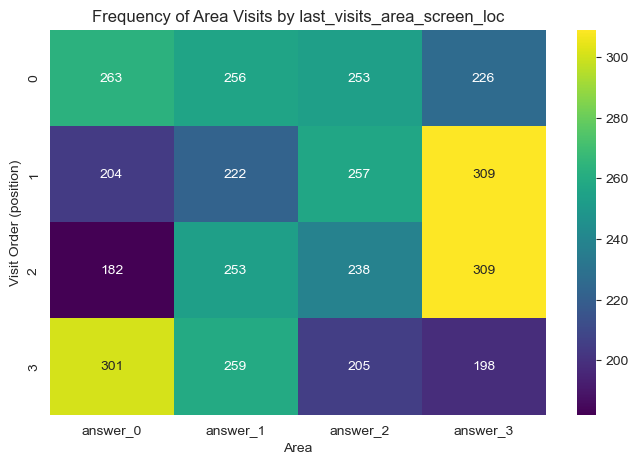

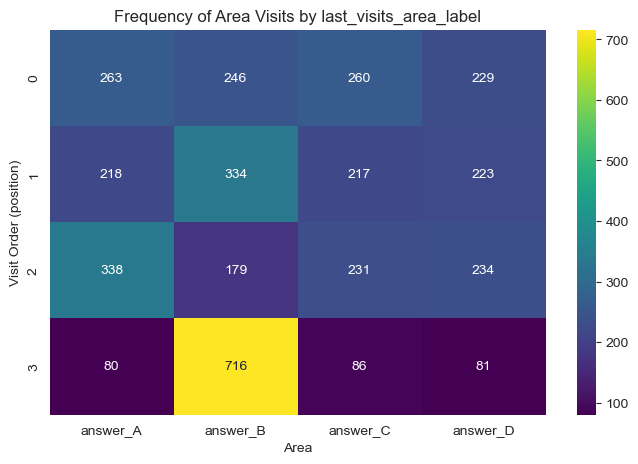


Participants who answered C:
--------------------------------------------------------------------------
####### First #######


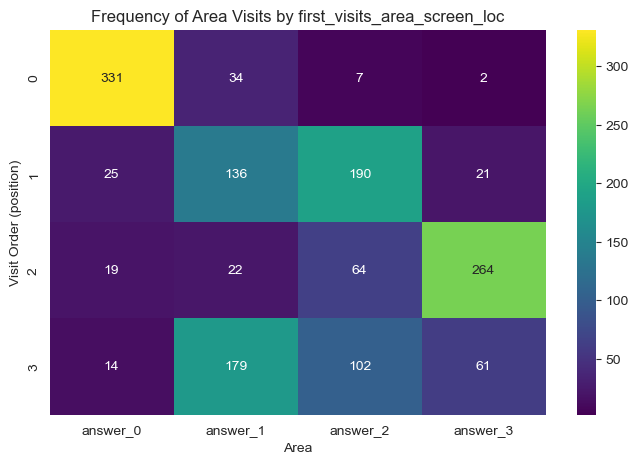

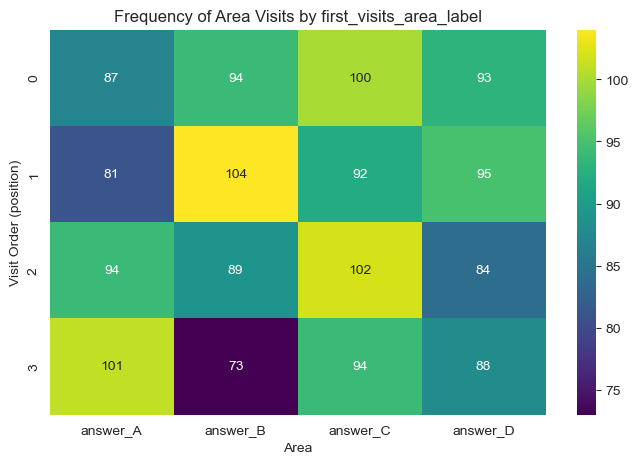

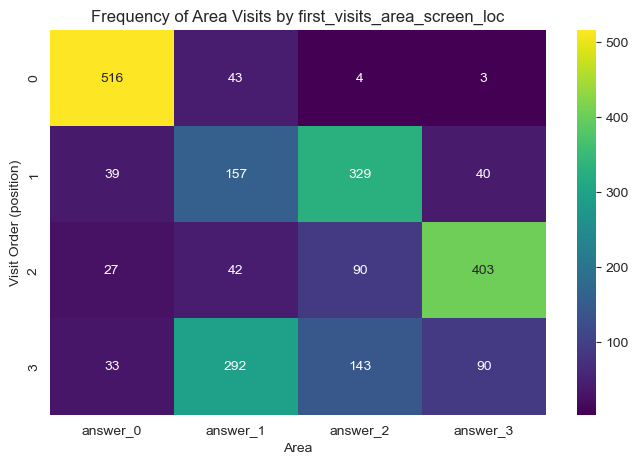

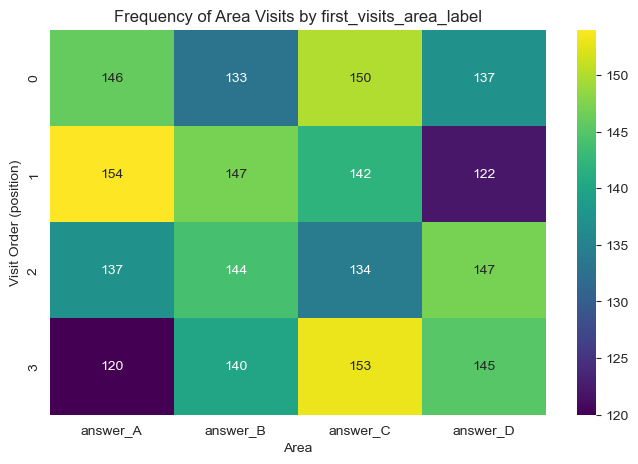

####### Last #######


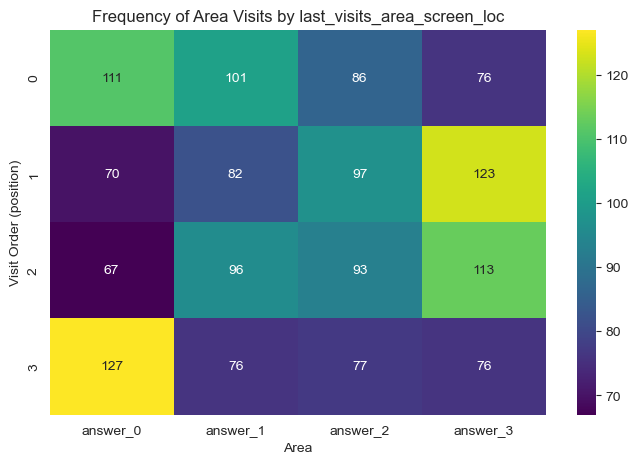

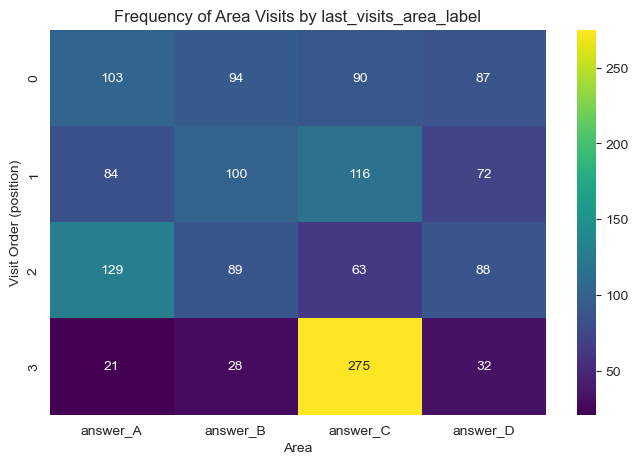

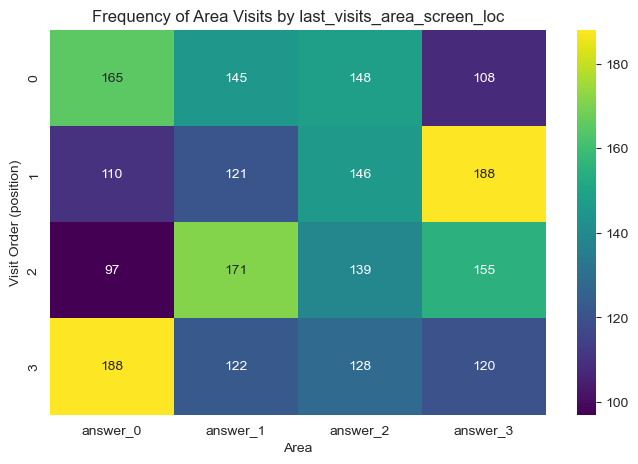

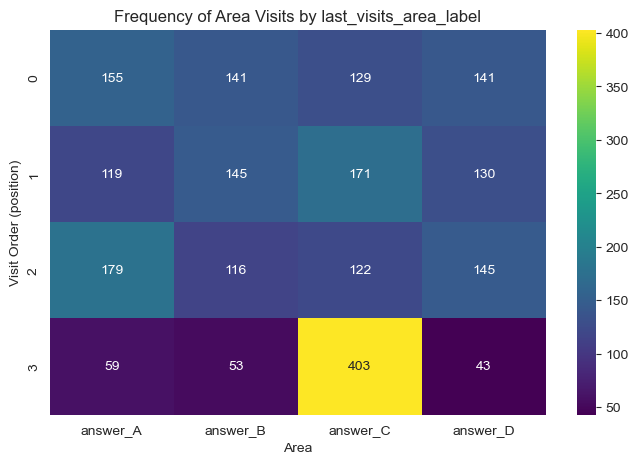


Participants who answered D:
--------------------------------------------------------------------------
####### First #######


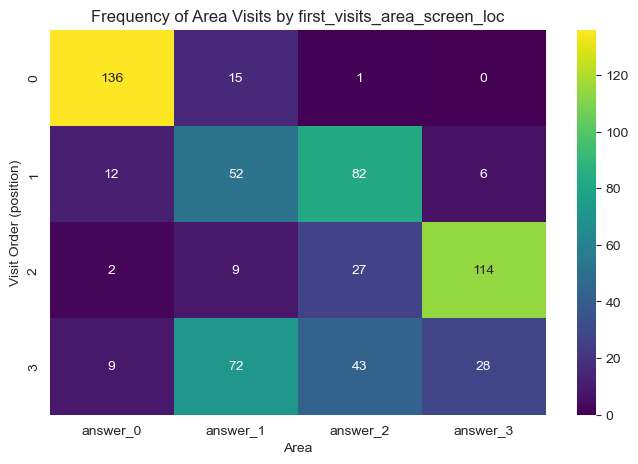

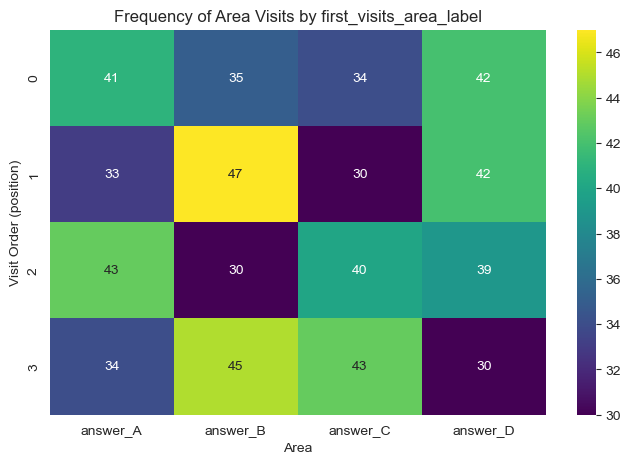

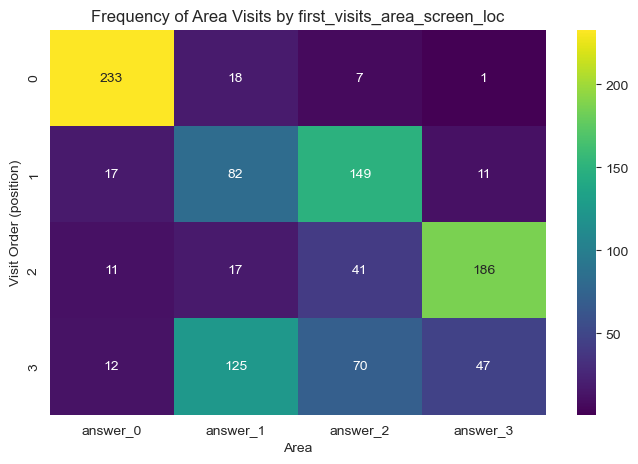

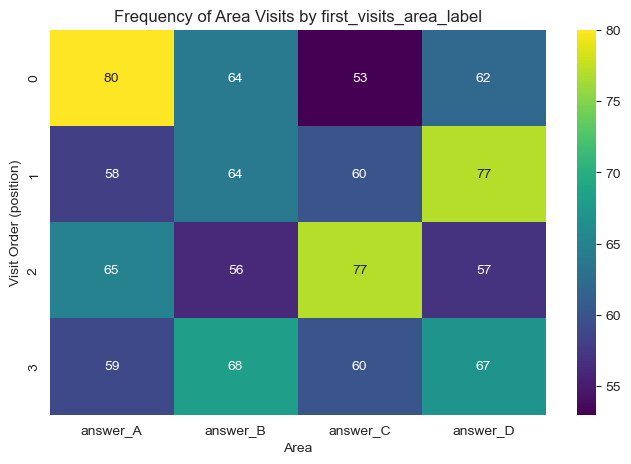

####### Last #######


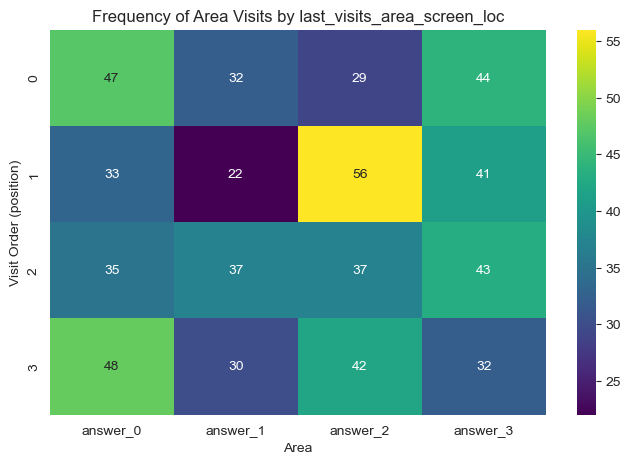

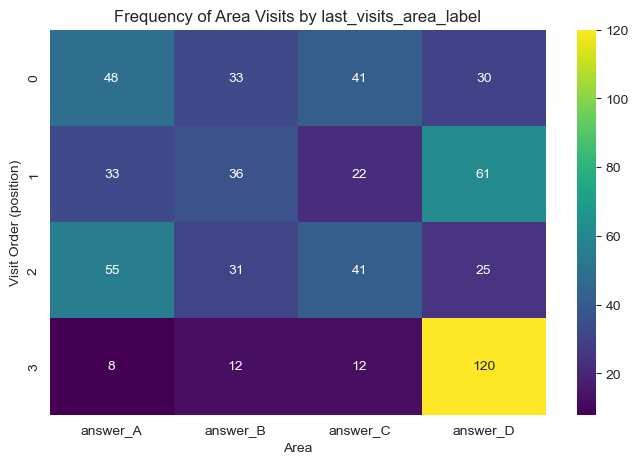

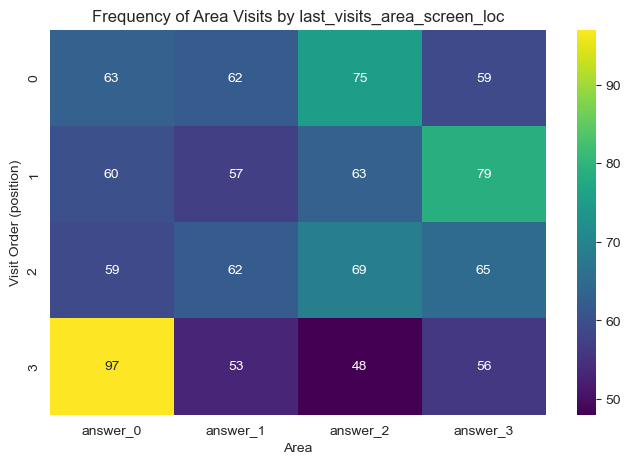

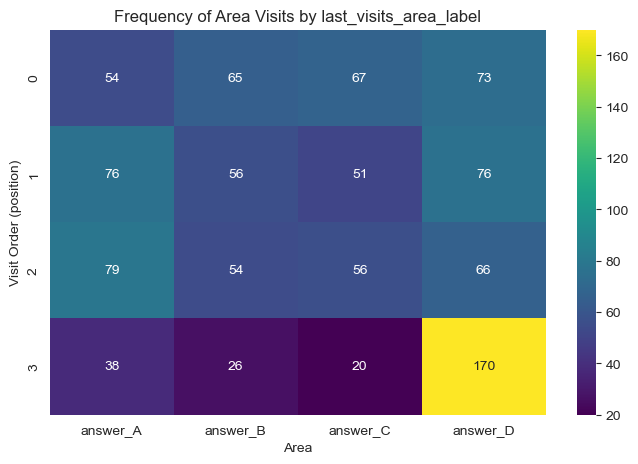

In [19]:
plot_all_by_answer(
    matrix_plot_visits,
    df_noq_h,
    df_noq_g,
    with_questions=False,
)

### Dominant Strategies

In [20]:
def proportion_with_dominant_strategy(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',threshold = 0.8):
    counts = df.groupby([id_col, strat_col]).size()
    total = counts.groupby(level=0).sum()
    top = counts.groupby(level=0).max()
    prop = top / total
    is_dominant = prop > threshold
    return is_dominant.mean()

In [21]:
threshold = 0.5
ph = proportion_with_dominant_strategy(df_with_features_h, strat_col = 'first_visits_area_screen_loc',threshold = threshold)
pg = proportion_with_dominant_strategy(df_with_features_g, strat_col = 'first_visits_area_screen_loc',threshold = threshold)

print(f"{ph:.1%} of hunter participants had a dominant strategy (>{threshold*100}% of trials).")
print(f"{pg:.1%} of gatherer participants had a dominant strategy (>{threshold*100}% of trials).")

56.7% of hunter participants had a dominant strategy (>50.0% of trials).
67.8% of gatherer participants had a dominant strategy (>50.0% of trials).


In [22]:
def plot_dominant_strategy_hist(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                            bins = 20, figsize = (6, 4), h_or_g = 'h', save = True):

    counts = df.groupby([id_col, strat_col]).size()
    total = counts.groupby(level=0).sum()
    top   = counts.groupby(level=0).max()
    dominant_prop = top / total

    if isinstance(bins, int):
        bin_edges = np.linspace(0, 1, bins + 1)
    else:
        bin_edges = np.asarray(bins)

    plt.figure(figsize=figsize)
    plt.hist(dominant_prop, bins=bin_edges)
    plt.xlabel('Proportion of trials in dominant strategy')
    plt.ylabel('Number of participants')
    plt.title(f'Distribution of Dominant-Strategy Usage ({h_or_g})')
    ticks = bin_edges
    plt.xticks(ticks, [f"{int(x*100)}%" for x in ticks], rotation=45)
    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/dominant_prop_{strat_col}_{h_or_g}.png")
    plt.show()


    return dominant_prop

In [23]:
def plot_dominance_gap(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                        bins = 20, figsize = (12, 5) , h_or_g = 'h', save = True,
                        hist_kwargs = None, scatter_kwargs = None):

    hist_kwargs   = hist_kwargs   or {'edgecolor':'k'}
    scatter_kwargs = scatter_kwargs or {'alpha':0.7}

    counts = df.groupby([id_col, strat_col]).size().unstack(fill_value=0)
    props = counts.div(counts.sum(axis=1), axis=0)

    p1 = props.max(axis=1)
    def second_largest(row):
        vals = row[row>0].nlargest(2)
        return vals.iloc[-1] if len(vals)>1 else 0
    p2 = props.apply(second_largest, axis=1)
    gap = p1 - p2

    result = pd.DataFrame({'p1': p1, 'p2': p2, 'gap': gap})

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    axes[0].hist(gap, bins=bins, **hist_kwargs)
    axes[0].set_xlabel('Gap (P1 – P2)')
    axes[0].set_ylabel('Number of participants')
    axes[0].set_title(f'Histogram of Dominance Gaps ({h_or_g}) ')

    axes[1].scatter(p2, p1, **scatter_kwargs)
    axes[1].plot([0,1], [0,1], 'r--', label='P1=P2')
    axes[1].set_xlabel('2nd-most common proportion (P2)')
    axes[1].set_ylabel('Most common proportion (P1)')
    axes[1].set_title(f'P2 vs. P1 per Participant ({h_or_g})')
    axes[1].legend()

    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/dominance_gap_{strat_col}_{h_or_g}.png")
    plt.show()

    return result

In [24]:
def plot_strategy_count_distribution(df, id_col='participant_id', strat_col='first_visits_area_screen_loc',
                                     figsize=(6, 4), bins=None, h_or_g='h', save=True, **plot_kwargs):
    strat_counts = df.groupby(id_col)[strat_col].nunique()

    plt.figure(figsize=figsize)
    if bins is None:
        max_strat = strat_counts.max()
        bins = np.arange(0.5, max_strat + 1.5, 1.0)
    plt.hist(strat_counts, bins=bins, **plot_kwargs)
    plt.xlabel('Number of distinct strategies used')
    plt.ylabel('Number of participants')
    plt.title(f'Distribution of Strategy Counts ({h_or_g})')
    ticks = np.arange(1, strat_counts.max() + 1)
    plt.xticks(ticks)

    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/dom_str_counts_{strat_col}_{h_or_g}.png")

    plt.show()

    return strat_counts


In [25]:
def plot_dominant_strategy_counts_above_threshold(df, id_col = 'participant_id', strat_col = 'first_visits_area_screen_loc',
                                                threshold = 0.5, figsize = (8, 4), h_or_g = 'h', save = True, **bar_kwargs):

    counts = df.groupby([id_col, strat_col]).size().unstack(fill_value=0)
    props = counts.div(counts.sum(axis=1), axis=0)
    dominant_prop = props.max(axis=1)
    dominant_strat = props.idxmax(axis=1)
    mask = dominant_prop >= threshold
    filtered = dominant_strat[mask]
    freq = filtered.value_counts()
    freq = freq.sort_values(ascending=False)


    plt.figure(figsize=figsize)
    freq.plot(kind='bar', **bar_kwargs)
    plt.xlabel(strat_col)
    plt.ylabel('Number of participants')
    pct = int(threshold * 100)
    plt.title(f'Dominant Strategies (≥ {pct}% of trials) — Count of Participants ({h_or_g})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        plt.savefig(f"plots/strategies/str_above_thresh_{strat_col}_{h_or_g}.png")

    plt.show()

    return freq

In [26]:
def build_prefix_completion_map_from_series(series, full_len=4):
    full_counts = series[series.map(len).eq(full_len)].value_counts()
    by_prefix = defaultdict(Counter)
    for full_seq, c in full_counts.items():
        for k in range(1, full_len):
            pref = full_seq[:k]
            by_prefix[pref][full_seq] += c
    prefix2full = {
        pref: max(counter.items(), key=lambda kv: (kv[1], kv[0]))[0]
        for pref, counter in by_prefix.items()
    }
    return prefix2full


def add_completed_sequence_column(
        df,
        strat_col='first_visits_area_screen_loc',
        full_len=4,
        col_suffix='_completed',
        prefix2full=None,
    ):

    df = df.copy()
    series = df[strat_col]

    if prefix2full is None:
        prefix2full = build_prefix_completion_map_from_series(series, full_len=full_len)

    def _complete(t):
        if len(t) >= full_len:
            return t[:full_len]
        return prefix2full.get(t, t)
    comp = series.map(_complete)
    comp_col = f"{strat_col}{col_suffix}"
    df[comp_col] = comp

    return df, prefix2full


In [27]:
df_with_features_h, prefix_map_h = add_completed_sequence_column(
    df_with_features_h,
    strat_col='first_visits_area_screen_loc',
    full_len=4,
    col_suffix='_completed',
    prefix2full=None
)

df_with_features_g, prefix_map_g = add_completed_sequence_column(
    df_with_features_g,
    strat_col='first_visits_area_screen_loc',
    full_len=4,
    col_suffix='_completed',
    prefix2full=None

)

In [28]:
def plot_strategies(df, id_col,strat_col, h_or_g = 'h', save = True):
    dominant = plot_dominant_strategy_hist(
        df,
        id_col=id_col,
        strat_col=strat_col,
        bins=20,
        figsize=(8,5),
        h_or_g = h_or_g,
        save = save
    )

    comp_dom = plot_dominant_strategy_hist(
        df,
        id_col=id_col,
        strat_col=strat_col + '_completed',
        bins=20,
        figsize=(8,5),
        h_or_g = h_or_g,
        save = save
    )

    gaps = plot_dominance_gap(
        df,
        id_col=id_col,
        strat_col=strat_col,
        bins=20,
        figsize=(10,4),
        h_or_g = h_or_g,
        save = save
    )

    counts = plot_strategy_count_distribution(
        df,
        id_col=id_col,
        strat_col = strat_col,
        h_or_g = h_or_g,
        save = save
    )

    strategies = plot_dominant_strategy_counts_above_threshold(
        df,
        id_col=id_col,
        strat_col=strat_col,
        threshold=0.5,
        h_or_g = h_or_g,
        save = save
    )


    return dominant, comp_dom, gaps, counts,strategies

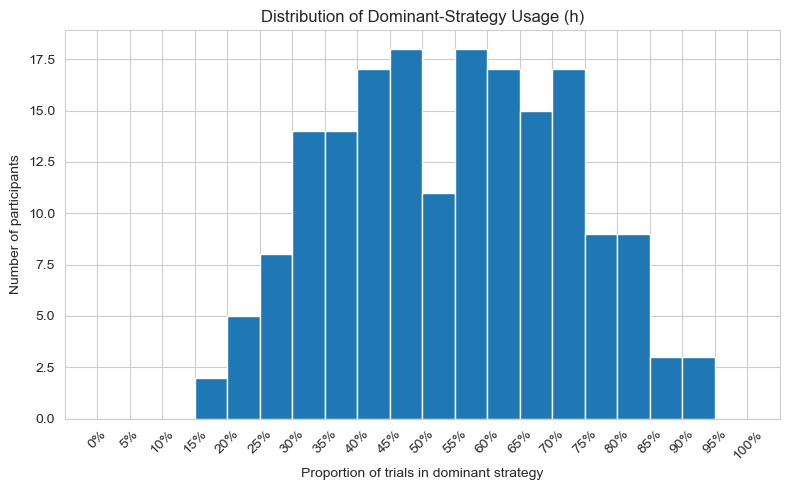

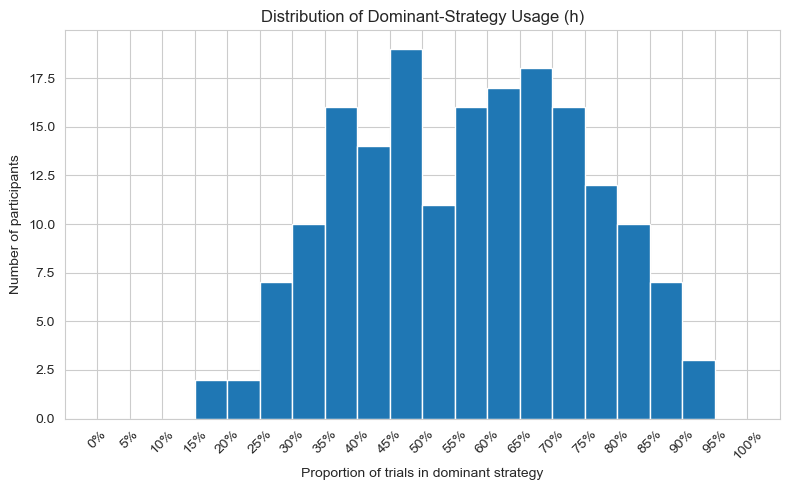

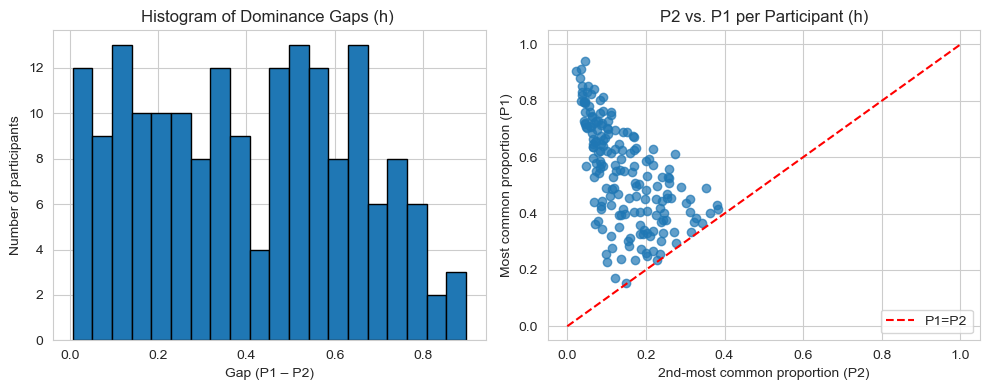

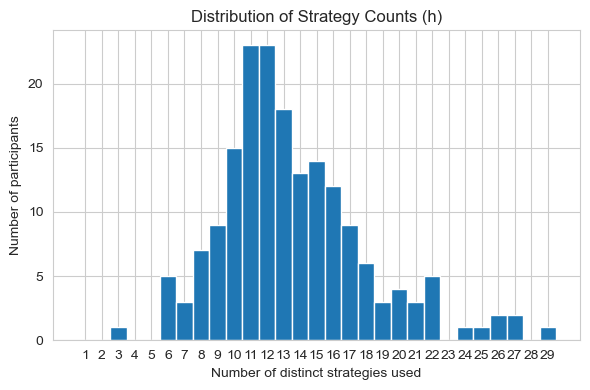

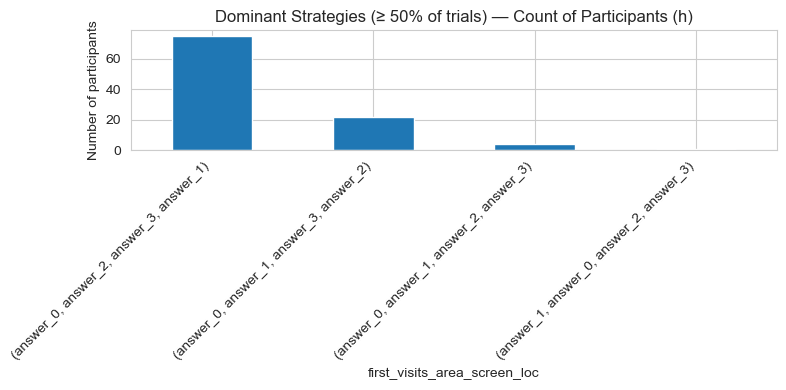

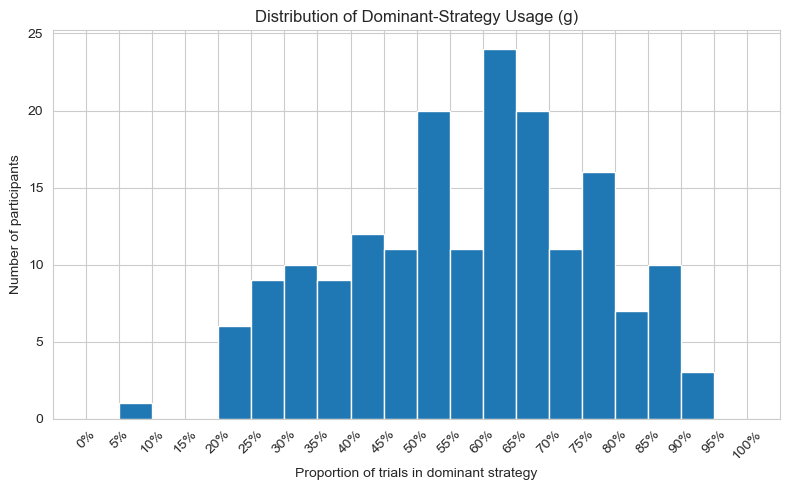

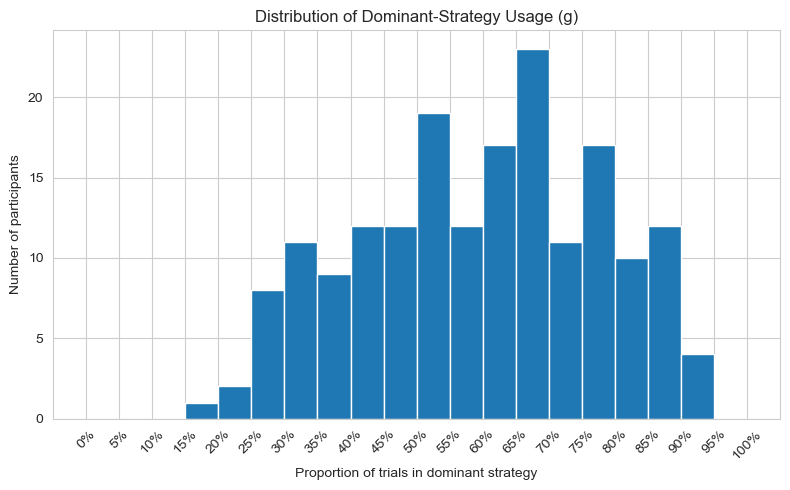

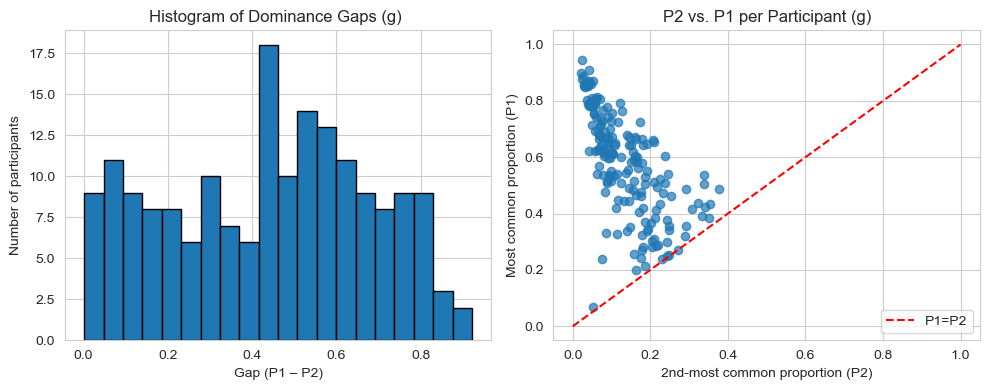

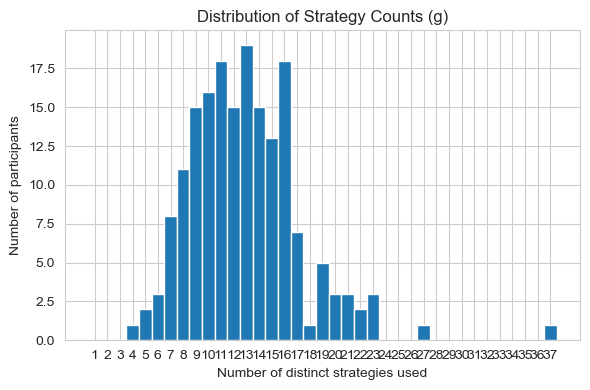

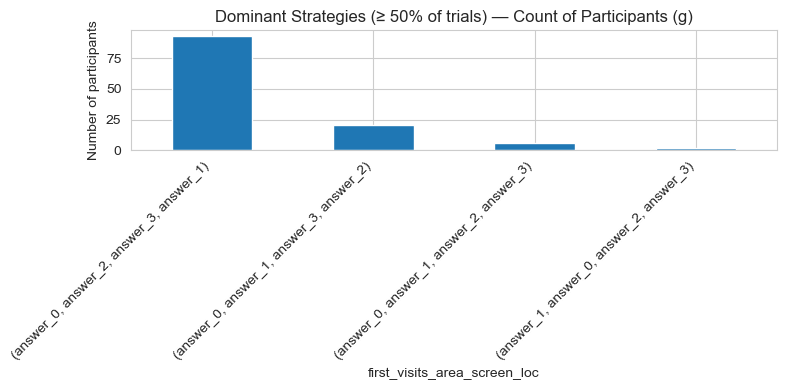

In [29]:
dh, cdh, gh, ch, sh = plot_strategies(df_with_features_h, id_col='participant_id',strat_col='first_visits_area_screen_loc', h_or_g='h',save=False)
dg, cdg, gg, cg, sg = plot_strategies(df_with_features_g, id_col='participant_id',strat_col='first_visits_area_screen_loc', h_or_g='g', save=False)

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize_before_after(
    df,
    id_col='participant_id',
    raw_col='first_visits_area_screen_loc',
    comp_col='first_visits_area_screen_loc_completed',
    threshold=0.5,
    bins=20,
    figsize=(8,5),
    h_or_g='h',
    save=True,
    out_prefix="plots/strategies/",
    density=False,
    hist_kwargs=None,
    full_len=4,
):

    hist_kwargs = hist_kwargs or {'alpha':0.5, 'edgecolor':'k'}

    counts_raw = df.groupby([id_col, raw_col]).size().unstack(fill_value=0)
    prop_raw   = counts_raw.max(axis=1) / counts_raw.sum(axis=1)
    dom_raw    = counts_raw.idxmax(axis=1)

    counts_comp = df.groupby([id_col, comp_col]).size().unstack(fill_value=0)
    prop_comp   = counts_comp.max(axis=1) / counts_comp.sum(axis=1)
    dom_comp    = counts_comp.idxmax(axis=1)

    both = pd.DataFrame({'raw': prop_raw, 'comp': prop_comp}).dropna()
    both['delta'] = both['comp'] - both['raw']

    both['raw_label'] = dom_raw.reindex(both.index)
    both['comp_label'] = dom_comp.reindex(both.index)
    both['changed_label'] = (both['raw_label'] != both['comp_label'])

    comp_series = df[comp_col]
    raw_series  = df[raw_col]
    mask_valid  = comp_series.notna() & raw_series.notna()


    def _norm(t):
        if t is None: return None
        return t[:full_len] if len(t) > full_len else t

    changed_rows = (comp_series[mask_valid].map(_norm) != raw_series[mask_valid].map(_norm))

    per_part_changed = (
        pd.DataFrame({
            'changed': changed_rows,
            'total':   True
        })
        .assign(**{id_col: df.loc[mask_valid, id_col].values})
        .groupby(id_col)
        .agg(
            seq_pct_changed=('changed', lambda s: float(s.mean()) if len(s) else np.nan),
            seq_changed_n=('changed', 'sum'),
            seq_total_n=('total', 'sum'),
        )
    )

    both = both.join(per_part_changed, how='left')

    changed_n = int(both['changed_label'].sum())
    changed_pct = float(changed_n / len(both) * 100) if len(both) else np.nan
    mean_seq_pct_changed = float(both['seq_pct_changed'].mean()*100) if both['seq_pct_changed'].notna().any() else np.nan
    median_seq_pct_changed = float(both['seq_pct_changed'].median()*100) if both['seq_pct_changed'].notna().any() else np.nan

    summary = {
        'participants': int(len(both)),
        'mean_raw': float(both['raw'].mean()) if len(both) else np.nan,
        'mean_completed': float(both['comp'].mean()) if len(both) else np.nan,
        'mean_delta': float(both['delta'].mean()) if len(both) else np.nan,
        f'raw_≥{int(threshold*100)}%': float((both['raw']  >= threshold).mean()*100) if len(both) else np.nan,
        f'comp_≥{int(threshold*100)}%': float((both['comp'] >= threshold).mean()*100) if len(both) else np.nan,
        'changed_label_n': changed_n,
        'changed_label_pct': changed_pct,
        'mean_seq_pct_changed': mean_seq_pct_changed,
        'median_seq_pct_changed': median_seq_pct_changed,
    }

    bin_edges = np.linspace(0, 1, bins + 1) if isinstance(bins, int) else np.asarray(bins)
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(both['raw'],  bins=bin_edges, density=density, label='Raw',       **hist_kwargs)
    ax.hist(both['comp'], bins=bin_edges, density=density, label='Completed', **hist_kwargs)
    ax.set_xlabel('Proportion of trials in dominant strategy')
    ax.set_ylabel('Density' if density else 'Number of participants')
    ax.set_title(f'Dominant-Strategy Proportion: Raw vs Completed ({h_or_g})')
    ax.set_xticks(bin_edges)
    ax.set_xticklabels([f"{int(x*100)}%" for x in bin_edges], rotation=45)
    ax.legend()
    plt.tight_layout()
    if save:
        os.makedirs(out_prefix, exist_ok=True)
        plt.savefig(os.path.join(out_prefix, f"dominant_prop_raw_vs_completed_{h_or_g}.png"))
    plt.show()

    return summary, both, fig, ax


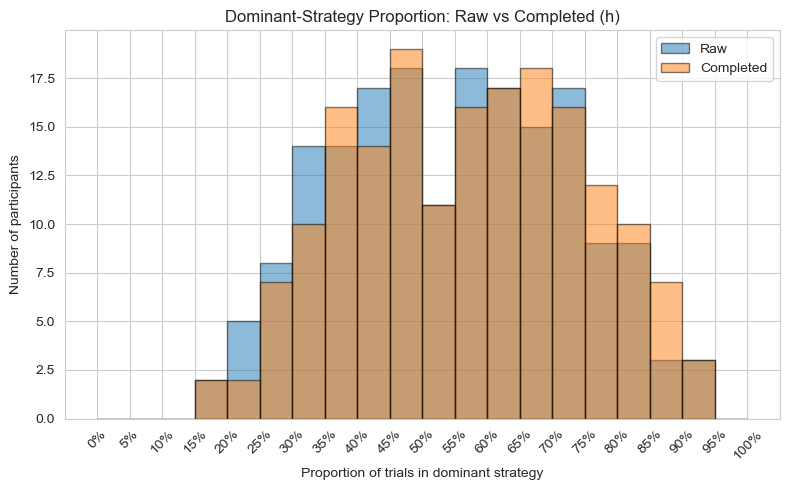

{'participants': 180, 'mean_raw': 0.545071294098646, 'mean_completed': 0.5685980448960518, 'mean_delta': 0.023526750797405762, 'raw_≥50%': 56.666666666666664, 'comp_≥50%': 61.111111111111114, 'changed_label_n': 2, 'changed_label_pct': 1.1111111111111112, 'mean_seq_pct_changed': 5.927475134275812, 'median_seq_pct_changed': 3.8650710166710454}


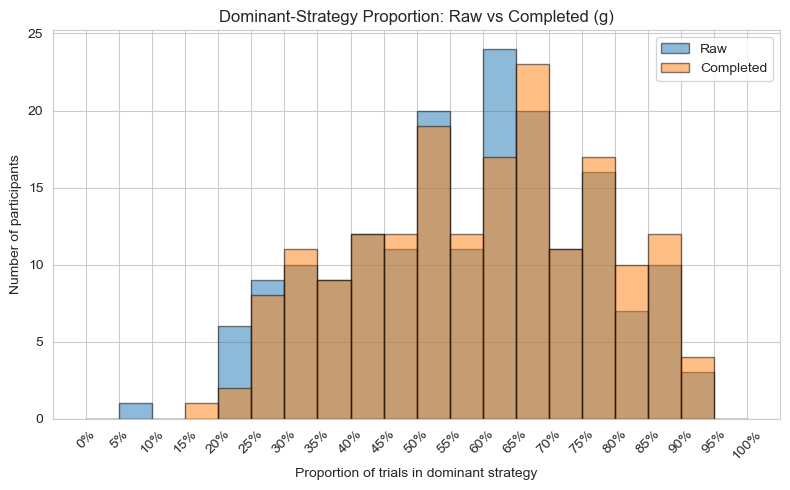

{'participants': 180, 'mean_raw': 0.5758223554246892, 'mean_completed': 0.5949500849462652, 'mean_delta': 0.019127729521576004, 'raw_≥50%': 67.77777777777779, 'comp_≥50%': 69.44444444444444, 'changed_label_n': 3, 'changed_label_pct': 1.6666666666666667, 'mean_seq_pct_changed': 4.398615785150238, 'median_seq_pct_changed': 2.254136602363952}


In [31]:
summary_h, table_h, fig_h, ax_h = summarize_before_after(
    df_with_features_h,
    id_col='participant_id',
    raw_col='first_visits_area_screen_loc',
    comp_col='first_visits_area_screen_loc_completed',
    threshold=0.5,
    bins=20,
    h_or_g='h',
    save=True
)
print(summary_h)

summary_g, table_g, fig_g, ax_g = summarize_before_after(
    df_with_features_g,
    id_col='participant_id',
    raw_col='first_visits_area_screen_loc',
    comp_col='first_visits_area_screen_loc_completed',
    threshold=0.5,
    bins=20,
    h_or_g='g',
    save=True
)
print(summary_g)